In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from pyvis import network as net
from pyvis.network import Network
import random
#from serpapi import GoogleScholarSearch
import json
import requests

# Creation of DataFarme

In [55]:
#import given dataframe nodes
nodes = pd.read_csv("Data/nodes.csv")

nodes['author_id'] = None
nodes['cited_by'] = None 
nodes['interests'] = None
nodes.to_csv('Data/nodes.csv', index=False)

edges = pd.DataFrame(columns=['author1','author2']) 
edges.to_csv('Data/edges.csv', index=False)

## ES 1
A partire da nodes.csv, utilizzare la libreria Python SerpAPI per scaricare, per ciascuno dei 7 autori elencati:
- author_id: ID identificativo del profilo Google Scholar
- cited_by: numero totale di citazioni ricevute
- interests: elenco degli interessi di ciascun autore
Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per aggiornare il file originale con apposite colonne e memorizzarlo nella cartella /data.

In [27]:
#dictionary with the keys
listApikey ={
    'SERP_API_KEY_FAVA': "1ae8a37d9b3dabb5732fcd7a9cb57410194766951242a4f4ac5bbd9fb7012048", 
    'SERP_API_KEY_LIGUGNANA': "11a077a8bee5bb1c2a25af914046bc7ce53050b3416e5720239e43223c63374b",
    'SERP_API_KEY_PARAVANO' :  "42b4919fd319f0ff32c19ae31a88b4ff67a544e29ca2a017905088b2ae11e60e",
    'SERP_API_KEY_TAMMARO': "6eaf5a9a0d2eef8bf026a947a3dffbb0d31cb1d6e122b81c0e6062f6b23a4c40"
}

#key in use right now
apikey = "26eb1104ccb6c743b29cf9dbc6e9bf89f8f2cfae60daf9a82c4feb2cc932c52a"

#function to randomise the key in use
'''
def key_choice():
    return random.choice(list(apikey.items()))[1]
'''


'\ndef key_choice():\n    return random.choice(list(apikey.items()))[1]\n'

In [16]:
#overwrite the row of nodes with df_update in the right position
#if the author given isn't in nodes, then it will get concatenated

def update_nodes(df_update, nodes):
    
    #read nodes csv
    nodesMod = pd.read_csv(r'Data/nodes.csv')

    print('nome: ', df_update["name"][0])

    #check if the author is in nodes using attributre name as parameter
    if (nodes["name"] == df_update["name"][0]).any():
        print('già presente in nodes')
        #if author is already in nodes update the present row with df_update
        for index in range(len(nodes)):
            if nodes["name"][index] == df_update["name"][0]:
                print('sta sovrascrivendo con: ', df_update.iloc[0])
                nodesMod.iloc[index]=df_update.iloc[0]
                nodesMod.to_csv(r'Data/nodes.csv', index=False) #overwrite the csv with the new row
    else:
        #if the author isn't already in nodes we concatenete it
        nodesMod = pd.concat([nodesMod, df_update], ignore_index=True)
        nodesMod.to_csv(r'Data/nodes.csv', index=False) #overwrite the csv by adding df_update at the end
            

In [17]:
# author_profile returns a dataframe with name, affiliations, author_id, cited_by, interests of a given author

def author_profile(apiKey, name, affiliation, nodes):

    base_url = "https://serpapi.com/search"

    # search among scholar profiles for the one with the given name
    params = {
        "api_key": apiKey,
        "engine": "google_scholar_profiles",
        "hl": "en",
        "mauthors": name
    }

    # save the request response in json
    response = requests.get(base_url, params=params)
    results = response.json()

    # save the results in a json
    name_json = "json/" + name + ".json"

    with open(name_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)

    print(results)

    # scroll through profiles to verifies if the profile found is the one that wa are searching for
    for profile in results["profiles"]:
        interests = ''
        if (affiliation in profile["affiliations"]) and (name in profile["name"]):
            # save the information needed for the right author
            authorId = profile["author_id"]
            citedBy = profile["cited_by"]
            if 'interests' in profile:
                if profile["interests"] != '':
                    interests = ", ".join([i['title'] for i in profile["interests"]])  # select only titles for each interest, join to remove the square brackets (now seen as a single string instead of a list)
            else:
                profile["interests"] = ''

            # create a new row of the dataframe with all the information needed and return it
            df_update = pd.DataFrame({'name': [name],'affiliations': [affiliation],'author_id': [authorId],'cited_by': [citedBy],'interests': [interests]})

            update_nodes(df_update, nodes)

In [54]:
nodes = pd.read_csv("Data/nodes.csv")

print(author_profile(apikey,"Wolfgang Nejdl" ,"Professor of Computer Science, Leibniz Universität Hannover, L3S Research Center …", nodes))


{'search_metadata': {'id': '6567550937014cca95498a29', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/348534f47eb0b84d/6567550937014cca95498a29.json', 'created_at': '2023-11-29 15:13:13 UTC', 'processed_at': '2023-11-29 15:13:13 UTC', 'google_scholar_profiles_url': 'https://scholar.google.com/citations?mauthors=Wolfgang+Nejdl&view_op=search_authors&hl=en', 'raw_html_file': 'https://serpapi.com/searches/348534f47eb0b84d/6567550937014cca95498a29.html', 'total_time_taken': 0.86}, 'search_parameters': {'engine': 'google_scholar_profiles', 'mauthors': 'Wolfgang Nejdl', 'hl': 'en'}, 'profiles': [{'name': 'Wolfgang Nejdl', 'link': 'https://scholar.google.com/citations?hl=en&user=LC62bdYAAAAJ', 'serpapi_link': 'https://serpapi.com/search.json?author_id=LC62bdYAAAAJ&engine=google_scholar_author&hl=en', 'author_id': 'LC62bdYAAAAJ', 'affiliations': 'Professor of Computer Science, Leibniz Universität Hannover, L3S Research Center …', 'email': 'Verified email at kbs.uni-hannove

In [8]:
#nodes_information return a dataframe with name, affiliations, author_id, cited_by, interests;
#for each node in the given dataframe containing name and affiliation for each author 

def nodes_information(apikey, df):
    
    #iterate the row of the given df, for each one makes the call to the author_profile
    for index, row in df.iterrows():
        author_data = author_profile(apikey, row['name'], row['affiliations'])
        

## Main es 1

In [142]:
#get the final dataframe of the 7 originals authors with name, affiliations, author_id, cited_by, interests 
nodes_information(apikey, nodes)

## 2. Analisi dei Coautori tramite SerpAPI su Google Scholar

### a. Ottenere i Coautori dei 7 Autori Principali

Per ciascuno dei 7 autori, utilizzare il suo ID per accedere al relativo profilo Google Scholar e scaricare l'elenco dei suoi coautori utilizzando SerpAPI. Con tale elenco di nomi:;

#### a.1. Ricerca dei Coautori su Google Scholar

Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che corrisponde a ciascun nome nella lista di coautori. Per ogni risultato, salvare le informazioni come `name`, `affiliations`, `author_id`, `cited_by`, e `interests` in un nuovo DataFrame contenente tutte queste informazioni relative ai coautori dei 7 autori originari.

### b. Concatenazione dei DataFrame

Concatenare il DataFrame contenente le informazioni sui 7 autori principali con quello dei coautori generato al punto 2a in un unico DataFrame.

### c. Creazione del DataFrame delle Relazioni di Co-Authorship

Creare un terzo DataFrame con le colonne `author1` e `author2` che rappresenta le co-authorship. In questo DataFrame, una riga rappresenta un arco di coauthorship tra due autori. La co-authorship è binaria, non pesata.

#### Esempio

Se David La Barbera e Michael Soprano sono coautori, una riga del DataFrame creato al punto 2c rappresenterà questa relazione.

### Risultati Finali

A questo punto, saranno stati prodotti due DataFrame:

- Uno contenente le informazioni relative agli autori (originali + i relativi coautori), con le colonne `name`, `affiliations`, `cited_by`, `interests`. Salvare come `nodes.csv` nella cartella `/data` tale DataFrame.

- Un altro per le relazioni di co-authorship dai 7 autori principali verso i relativi coautori, con colonne `author1` e `author2`. Salvare come `edges.csv` nella cartella `/data` tale DataFrame.










In [25]:
def get_profile_coauthors(apiKey, authorID,nodes):
    base_url = "https://serpapi.com/search"

    #search among scholar profiles for the one with the given author_id
    params = {
        "api_key": apiKey,
        "engine": "google_scholar_author",
        "hl": "en",
        "author_id": authorID
    }
    response = requests.get(base_url, params = params)
    results = response.json()
    
    name_json = "json/"+authorID + ".json"
    with open(name_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    
    #crea solo un dataFrame di appoggio con colonna name e affiliations, secondo me non serve, ammno che non venga usato da qualche aletra parte
    authorName = results["author"]
    edges = pd.read_csv(r'Data/edges.csv')
    #for each coauthor save name and affiliation in a dataframe
    for coautore in results['co_authors']:
        coppie_da_cercare = [(authorName["name"], coautore['name']), (coautore['name'], authorName["name"])]
        #Cicla attraverso il DataFrame e verifica le condizioni
        trovato = True
        for index, row in edges.iterrows():
            if (row['author1'], row['author2']) in coppie_da_cercare or (row['author2'], row['author1']) in coppie_da_cercare:
                #esiste gia un collegamento tra aurtore e coautore o viceversa
                trovato = False
        if(trovato):
            row_edge = pd.DataFrame([{'author1' : authorName["name"], 'author2': coautore['name']}])
            edges = pd.concat([edges, row_edge], ignore_index=True)
        #adding coauthors to nodes

        if 'affiliations' in coautore:
            if coautore['affiliations'] == '':
                print('if ',coautore['affiliations'])
                author_profile(apiKey, coautore['name'], '', nodes)
            else:
                print('else ',coautore['affiliations'])
                author_profile(apiKey, coautore['name'], coautore['affiliations'], nodes)
        else:
            coautore['affiliations'] = ''

    edges.to_csv(r'Data/edges.csv', index=False)

In [28]:
nodes = pd.read_csv("Data/nodes.csv")

get_profile_coauthors(apikey,'egHDpFkAAAAJ',nodes)

else  Full professor of Computer Science and Information Technology
{'search_metadata': {'id': '656775840b50626127022c24', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/daba833fba74433e/656775840b50626127022c24.json', 'created_at': '2023-11-29 17:31:48 UTC', 'processed_at': '2023-11-29 17:31:48 UTC', 'google_scholar_profiles_url': 'https://scholar.google.com/citations?mauthors=Stefano+Mizzaro&view_op=search_authors&hl=en', 'raw_html_file': 'https://serpapi.com/searches/daba833fba74433e/656775840b50626127022c24.html', 'total_time_taken': 0.19}, 'search_parameters': {'engine': 'google_scholar_profiles', 'mauthors': 'Stefano Mizzaro', 'hl': 'en'}, 'profiles': [{'name': 'Stefano Mizzaro', 'link': 'https://scholar.google.com/citations?hl=en&user=2wvJC6IAAAAJ', 'serpapi_link': 'https://serpapi.com/search.json?author_id=2wvJC6IAAAAJ&engine=google_scholar_author&hl=en', 'author_id': '2wvJC6IAAAAJ', 'affiliations': 'Full professor of Computer Science and Information Techno

## Main es 2

In [17]:
##df_Coauthors = pd.DataFrame(columns=['name','affiliations','author_id','cited_by','interests'])
nodes = pd.read_csv(r'Data/nodes.csv')
for autore in nodes["author_id"]:
    get_profile_coauthors(apikey,autore,nodes)




# Parte 3
Usare il due dataset per creare grafico indiretto:
a. Generare un grafo indiretto che ne rappresenta le informazioni contenute.
Salvare (serializzare) il grafo in locale nella cartella /graphs .
b. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le
seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20, giallo per nodi con grado maggiore di 20. Inoltre, per ciascun nodo visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella /visualizations.




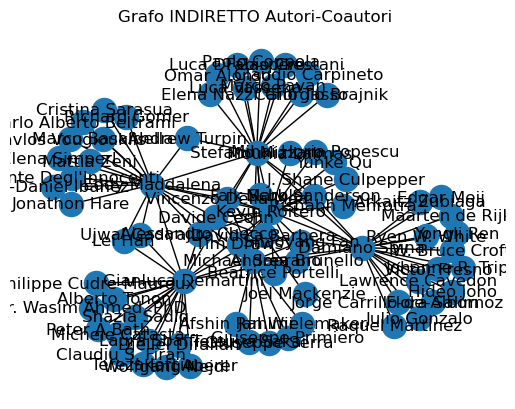

In [29]:
import matplotlib.pyplot as plt

# Creazione di un grafo vuoto
G = nx.Graph()
# Leggi i CSV
nodi = pd.read_csv('Data/nodes.csv')
edges = pd.read_csv('Data/edges.csv')
'''
# Aggiungi i nodi al grafo
nodes = nodi['name'].tolist()
G.add_nodes_from(nodes)

'''

# Aggiungi gli archi al grafo
edges = edges[['author1', 'author2']].values.tolist()
G.add_edges_from(edges)

# Aggiungi un titolo al grafo
plt.title("Grafo INDIRETTO Autori-Coautori ")

nx.draw(G, with_labels=True)


{'David La Barbera': 9, 'Michael Soprano': 1, 'Kevin Roitero': 1, 'Stefano Mizzaro': 1, 'Damiano Spina': 1, 'Gianluca Demartini': 1, 'Eddy Maddalena': 0, 'Vincenzo Della Mea': 1, 'Davide Ceolin': 1, 'Tim Draws': 1, 'Joel Mackenzie': 1}
{'David La Barbera': 'blue', 'Michael Soprano': 'gray', 'Kevin Roitero': 'gray', 'Stefano Mizzaro': 'gray', 'Damiano Spina': 'gray', 'Gianluca Demartini': 'gray', 'Vincenzo Della Mea': 'gray', 'Davide Ceolin': 'gray', 'Tim Draws': 'gray', 'Joel Mackenzie': 'gray'}


ValueError: 'c' argument has 10 elements, which is inconsistent with 'x' and 'y' with size 11.

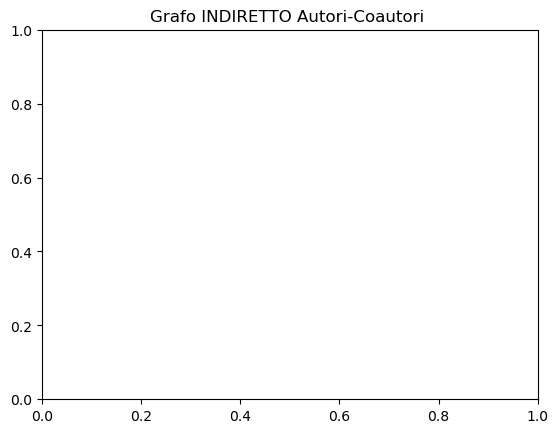

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
# Creazione di un grafo vuoto
G = nx.Graph()
# Leggi i CSV
nodi = pd.read_csv('Data/nodes.csv')
edges = pd.read_csv('Data/edges.csv')


# Aggiungi i nodi al grafo
nodes = nodi['name'].tolist()
G.add_nodes_from(nodes)

# Aggiungi gli archi al grafo
edges = edges[['author1', 'author2']].values.tolist()
G.add_edges_from(edges)

'''
grigio per nodi con grado uguale a 1, blu per nodi con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20, giallo per nodi con grado maggiore di 20
'''
#calcolo dela deegree
degrees = dict(G.degree())
print(degrees)
colori_specifici={}
for nodo, grado in degrees.items():
    if grado == 1:
        colori_specifici[nodo] = 'gray'
        #colore grigio
    elif grado in range(2, 10):
        colori_specifici[nodo] = 'blue'
        #colore blu
    elif grado in range(11, 20):
        colori_specifici[nodo] = 'purple'
    elif grado:
        colori_specifici[nodo] = 'yellow'
        #colore gioallo

# Aggiungi un titolo al grafo
plt.title("Grafo INDIRETTO Autori-Coautori ")

print(colori_specifici)
# 1.3 | Visualizzo il grafo
nx.draw(G, with_labels=True, node_color = colori_specifici.values())

{'David La Barbera': 9, 'Michael Soprano': 1, 'Kevin Roitero': 1, 'Stefano Mizzaro': 1, 'Damiano Spina': 1, 'Gianluca Demartini': 1, 'Eddy Maddalena': 0, 'Vincenzo Della Mea': 1, 'Davide Ceolin': 1, 'Tim Draws': 1, 'Joel Mackenzie': 1}
{'David La Barbera': 'blue', 'Michael Soprano': 'gray', 'Kevin Roitero': 'gray', 'Stefano Mizzaro': 'gray', 'Damiano Spina': 'gray', 'Gianluca Demartini': 'gray', 'Vincenzo Della Mea': 'gray', 'Davide Ceolin': 'gray', 'Tim Draws': 'gray', 'Joel Mackenzie': 'gray'}


ValueError: 'c' argument has 10 elements, which is inconsistent with 'x' and 'y' with size 11.

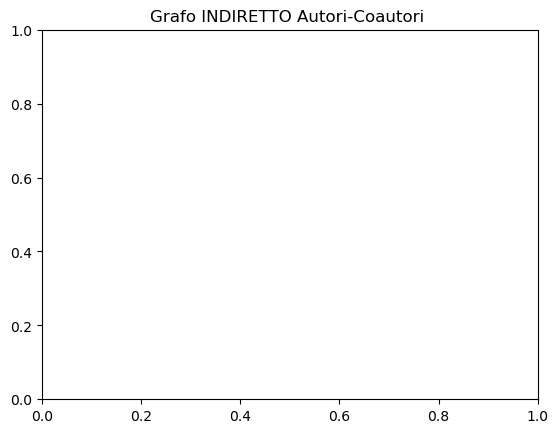

In [73]:
#ES 2
def draw(G, pos, measures, title):
    nodes = nx.draw_networkx_nodes(G, pos, node_size = 150, cmap = plt.cm.plasma,
                                   node_color  = list(measures.values()),
                                   nodelist = measures.keys()
                                   )
    edges = nx.draw_networkx_edges(G, pos)
    plt.title(title)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()
    # 2.1 | Genero grafo con proprietà piccolo mondo
G = nx.watts_strogatz_graph(15, 4, .3)

# 2.2 | Centralità di grado per tutti i nodi
degrees = dict(G.degree())
df = pd.DataFrame(list(degrees.items()), columns=['node', 'degree'])
print("Centralità di grado:")
display(df)


# 2.3 | Calcolo le altre priprietà richieste
num_edges = G.number_of_edges()
# Grado medio 
avg_degree = sum(degrees.values()) / G.number_of_nodes()
# Densità del grafo
density = nx.density(G)
# Nodo più connesso
max_degree_node = max(degrees, key=degrees.get)

print(f"Number of edges: {num_edges}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Density: {density:.2f}")
print(f"Most connected node: {max_degree_node}")
# 2.4 | Visualizzo usando lo spring layout
draw(
    G,
    nx.spring_layout(G),
    nx.degree_centrality(G),
    title = "Visualizzazione della rete Piccolo Mondo generata"
      )

In [1]:




#usare la stessa funzione iniziale, quando passi l'id del autore e restituisce tutti i dati, di cui recuprei i coautori, crei direttamente il datframe quello dei nodi, ciclano n-volte( che saranno il numero di coaurori, e crei una riga insrendo l'Id del autore + vicino il coautore.

NameError: name 'nodes' is not defined